# Název projektu
## 155UZPR - Katedra Geomatiky - Fsv ČVUT
### Tereza Černohousová - Matěj Klimeš
### ZS2024

In [32]:
import fiona
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib.request
import folium
import matplotlib
import mapclassify
import zipfile
import os
from eodag import EODataAccessGateway

Stažení data250 pro stanovení oblasti zájmu

In [2]:
# Source URL
url = "https://openzu.cuzk.cz/opendata/Data250/epsg-5514/data250.zip"

# Cílový adresář
zip_filename = "data250.zip"

# Stažení ZIP souboru
urllib.request.urlretrieve(url, zip_filename)
print(f"Soubor {zip_filename} byl úspěšně stažen.")

Soubor data250.zip byl úspěšně stažen.


Import vrstvi obcí ze staženého ZIPu

In [29]:
obce = gpd.read_file("data250.zip!/PolbndMunDA.shp")
obce.head()

,FCSUBTYPE,F_CODE,ICC,SHN0,SHN1,SHN2,SHN3,TAA,ICOB,NUTS3,ISN,NAMN,DESN,SHAPE_Leng,SHAPE_Area,geometry
0,1,FA001,CZ,CZ0000000000,CZ0100000000,UNK,CZ0100554782,1,554782,CZ010,4605,Praha,obec,157071.726075,4.963111e+08,"POLYGON ((-733582.756 -1034199.856, -733690.30..."
1,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201513482,1,513482,CZ020,4605,Vysoký Újezd,obec,13689.999181,4.064693e+06,"POLYGON ((-742125.829 -1072463.392, -742056.67..."
2,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529303,1,529303,CZ020,4605,Benešov,obec,54242.943513,4.682135e+07,"POLYGON ((-729711.586 -1073957.287, -729679.83..."
3,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529451,1,529451,CZ020,4605,Bystřice,obec,64917.905895,6.343932e+07,"POLYGON ((-730989.011 -1081012.603, -731007.23..."
4,1,FA001,CZ,CZ0000000000,CZ0200000000,CZ0201000000,CZ0201529478,1,529478,CZ020,4605,Čakov,obec,13297.559487,5.318608e+06,"POLYGON ((-716606.98 -1075299.75, -716493.11 -..."


Výběr geometrie pro zadanou oblast

<Axes: title={'center': 'Hranice obce: Katovice'}>

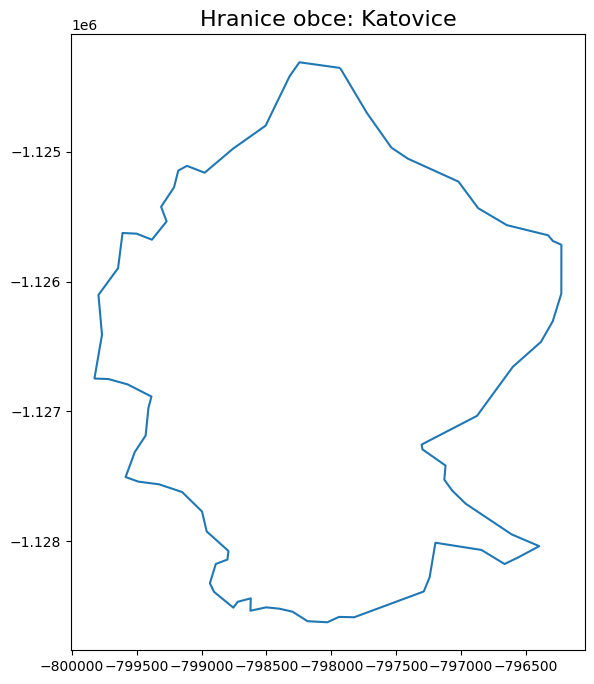

In [34]:
obec_zajmu = "Katovice"
aoi = obce[obce["NAMN"] == obec_zajmu]["geometry"]
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title(f"Hranice obce: {obec_zajmu}", fontsize=16)
aoi.boundary.plot(ax=ax)

In [35]:
aoi_map = aoi.set_crs(epsg=5514)
aoi_map.boundary.explore()

In [76]:
dag = EODataAccessGateway()
product = "S2_MSI_L2A"
dag.available_providers(product)

['astraea_eod',
 'cop_dataspace',
 'creodias',
 'onda',
 'planetary_computer',
 'sara']

In [77]:
extent = tuple(aoi_map.to_crs(4326).total_bounds)
extent
dag.set_preferred_provider("cop_dataspace")
results = dag.search(
    productType="S2_MSI_L2A",
    start="2024-10-01",
    end="2024-10-23",
    geom=tuple(extent),
    count=True
)
print(results.number_matched)

8


In [78]:
results_cc = results.filter_property(operator="le", cloudCover=5)
results_cc

SearchResult([EOProduct(id=S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806, provider=cop_dataspace)])

In [54]:
username = "cernote2@cvut.cz"
password = "Copernicus*2024UZPR"

dag.update_providers_config(f"""
cop_dataspace:
    download:
        extract: False
        outputs_prefix: /tmp/sentinel
        delete_archive: False
    auth:
        credentials:
            username: {username}
            password: {password}
""")

quicklooks/S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]


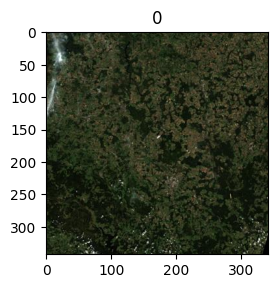

In [55]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 8))
for i, product in enumerate(results_cc, start=1):
    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()

    # Plot the quicklook
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(3, 4, i)
    ax.set_title(i - 1)
    plt.imshow(img)
plt.tight_layout()

In [57]:
# from pathlib import Path
# data_path = dag.download(results_cc[0])



0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806: 0.00B [00:00, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|                        | 0.00/1.18G [00:00<?, ?B/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|              | 65.5k/1.18G [00:00<1:57:16, 168kB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|                | 590k/1.18G [00:00<13:37, 1.44MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 1.44M/1.18G [00:00<05:57, 3.30MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 2.23M/1.18G [00:00<04:44, 4.15MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 3.01M/1.18G [00:00<03:51, 5.09MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806:   0%|               | 4.00M/1.18G [00:00<03:07, 6.29MB/s]
S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132

C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip True


In [58]:
# print(data_path, Path(data_path).exists())

C:\Users\terce\AppData\Local\Temp\S2B_MSIL2A_20241009T100829_N0511_R022_T33UVQ_20241009T132806.SAFE.zip True
